In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, lognorm

from model import lorenz63_fdm, M63, lorenz96_fdm, M96
from assimilation import EnKF, M3DVar, ExtendedKF

In [2]:
X_nature = np.load('./L96/data/X_nature.npy')
X_ini = np.load('./L96/data/X_ini.npy')
obs = np.load('./L96/data/obs_normal.npy')
ts = np.load('./L96/data/time_span.npy')
Pb = np.load('./L96/data/Pb_assum.npy')
R = np.load('./L96/data/R.npy')

dt = 0.01

# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

In [3]:
class DAbase:
    def __init__(self, model, dt, store_history=False):
        self._isstore = store_history
        self._params = {'alpha': 0, 'inflat': 1}
        self.model = model
        self.dt = dt
        self.X_ini = None
        
    def set_params(self, param_list, **kwargs):
        for key, value in kwargs.items():
            if key in param_list:
                self._params[key] = kwargs.get(key)
            else:
                raise ValueError(f'Invalid parameter: {key}')
        
    def _check_params(self, param_list):
        missing_params = []
        for var in param_list:
            if self._params.get(var) is None:
                missing_params.append(var)
        return missing_params
    
    
class EnKF(DAbase):
    def __init__(self, model, dt, store_history=False):
        super().__init__(model, dt, store_history)
        self._param_list = [
            'X_ens_ini', 
            'obs', 
            'obs_interv', 
            'R', 
            'H_func', 
            'alpha', 
            'inflat'
            #'local_type'
            #'localization'
        ]
        
    def list_params(self):
        return self._param_list
        
    def set_params(self, **kwargs):
        super().set_params(self._param_list, **kwargs)
        
    def _check_params(self):
        if self._params.get('H_func') is None:
            H_func = lambda arr: arr
            self._params['H_func'] = H_func
            
        missing_params = super()._check_params(self._param_list)
        if missing_params:
            raise ValueError(f"Missing parameters: {missing_params}")
            
    def _analysis(self, xb, yo, R, H_func=None):
        """xb.shape = (n_dim, n_ens)"""
        if H_func is None:
            H_func = lambda arr: arr
        
        N_ens = xb.shape[1]
        yo_ens = np.random.multivariate_normal(yo.ravel(), R, size=N_ens).T  # (ndim_yo, N_ens)
        xb_mean = xb.mean(axis=1)[:,np.newaxis]  # (ndim_xb, 1)
        
        xa_ens = np.zeros((xb.shape[0], N_ens))
        for iens in range(N_ens):
            xb_mean = xb.mean(axis=1)[:,np.newaxis]
            Xb_perturb = xb - xb_mean
            HXb_perturb = H_func(Xb_perturb) - H_func(Xb_perturb).mean(axis=1)[:,np.newaxis]
            
            PfH_T = Xb_perturb @ HXb_perturb.T / (N_ens-1)
            HPfH_T = HXb_perturb @ HXb_perturb.T / (N_ens-1)
            K = PfH_T @ np.linalg.inv(HPfH_T + R)
            xa_ens[:,[iens]] = xb[:,[iens]] + K @ (yo_ens[:,[iens]] - H_func(xb[:,[iens]]))
            
        return xa_ens
    
    def cycle(self):
        self._check_params()
        
        model = self.model
        dt = self.dt
        cycle_len = self._params['obs_interv']
        cycle_num = self._params['obs'].shape[1]
        
        xb = self._params['X_ens_ini'].copy()
        obs = self._params['obs']
        R = self._params['R']
        H_func = self._params['H_func']
        alpha = self._params['alpha']
        inflat = self._params['inflat']
        
        ndim, N_ens = xb.shape
        background = np.zeros((N_ens, ndim, cycle_len*cycle_num))
        analysis = np.zeros_like(background)
        
        t_start = 0
        ts = np.linspace(t_start, (cycle_len-1)*dt, cycle_len)
        
        for nc in range(cycle_num):
            # analysis
            xa = self._analysis(xb, obs[:,[nc]], R, H_func)
            
            # inflation
            xa_perturb = xa - xa.mean(axis=1)[:,np.newaxis]
            xa_perturb *= inflat
            xa = xa.mean(axis=1)[:,np.newaxis] + xa_perturb
            
            # ensemble forecast
            for iens in range(N_ens):
                x_forecast = model(xa[:,iens], ts)   # (ndim, ts.size)
                
                idx1 = nc*cycle_len
                idx2 = (nc+1)*cycle_len
                analysis[iens,:,idx1:idx2] = x_forecast
                background[iens,:,[idx1]] = xb[:,iens]
                background[iens,:,(idx1+1):idx2] = x_forecast[:,1:]
                
                # xb for next cycle
                xb[:,iens] = x_forecast[:,-1]
                
            # for next cycle
            t_start = int(ts[-1] + dt)
            ts = np.linspace(t_start, t_start+(cycle_len-1)*dt, cycle_len)
            
        self.background = background
        self.analysis = analysis

1.4044387371960314


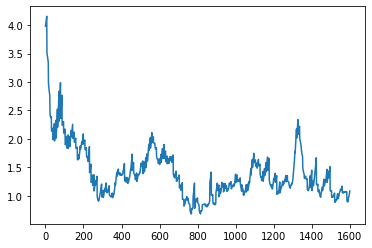

In [4]:
params = {
    'X_ens_ini': X_ens_ini, 
    'obs': obs,
    'obs_interv': 8, 
    'R': R, 
    'H_func': lambda arr: arr, 
    'alpha': 0.3,
    'inflat': 1.4
}
enkf = EnKF(lorenz96_fdm, dt)
enkf.set_params(**params)
enkf.cycle()

rmse = RMSE(enkf.analysis.mean(axis=0), X_nature)
plt.plot(rmse)
print(rmse.mean())